<a href="https://colab.research.google.com/github/ninayang2019/Marketing-Analytics-in-R/blob/master/Churn_rate_prediction_Shini_Yang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Churn rate prediction and recommendation

## Import modules and dataset

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use('ggplot')
sns.set_style()

data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv', sep=',')

In [2]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


##Data cleaning

In [3]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valores em falta', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
# Valores que estão faltando nos dados
missing_values = missing_values_table(data)

#Data Manipulation

#Replacing spaces with null values in total charges column
data['TotalCharges'] = data["TotalCharges"].replace(" ", np.nan)

#Dropping null values from total charges column which contain .15% missing data 
data = data[data["TotalCharges"].notnull()]
data = data.reset_index()[data.columns]

#convert to float type
data["TotalCharges"] = data["TotalCharges"].astype(float)

Your selected dataframe has 21 columns.
There are 0 columns that have missing values.


##EDA

In [0]:
replace_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'MultipleLines']

for i in replace_cols :
    data[i]  = data[i].replace({'No internet service' : 'No'})
    data[i]  = data[i].replace({'No phone service' : 'No'})
    

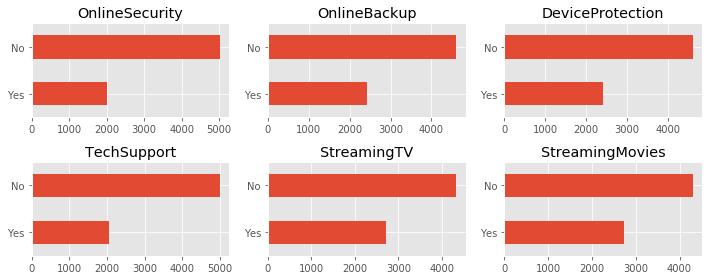

In [5]:
f, axes = plt.subplots(2, 3, sharey=False, sharex=False, figsize=(10,4))

data['OnlineSecurity'].value_counts(ascending=True).plot.barh(title='OnlineSecurity', ax=axes[0,0])
data['OnlineBackup'].value_counts(ascending=True).plot.barh(title='OnlineBackup', ax=axes[0,1])
data['DeviceProtection'].value_counts(ascending=True).plot.barh(title='DeviceProtection', ax=axes[0,2])
data['TechSupport'].value_counts(ascending=True).plot.barh(title='TechSupport', ax=axes[1,0])
data['StreamingTV'].value_counts(ascending=True).plot.barh(title='StreamingTV', ax=axes[1,1])
data['StreamingMovies'].value_counts(ascending=True).plot.barh(title='StreamingMovies', ax=axes[1,2])
plt.tight_layout()

In [6]:
data['Contract'].value_counts(ascending=True, normalize=True)

One year          0.209329
Two year          0.239619
Month-to-month    0.551052
Name: Contract, dtype: float64

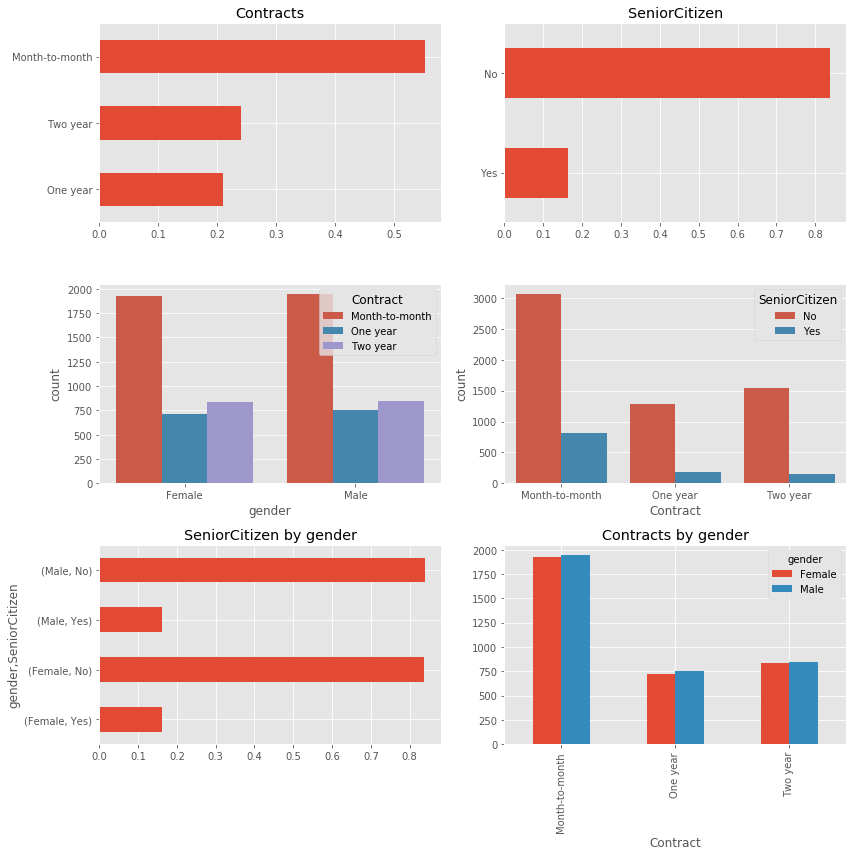

In [7]:
#replace values
data["SeniorCitizen"] = data["SeniorCitizen"].replace({1:"Yes",0:"No"})
f, axes = plt.subplots(3, 2, sharey=False, sharex=False, figsize=(12,12))

data['Contract'].value_counts(ascending=True, normalize=True).plot.barh(title='Contracts', ax=axes[0,0])
data['SeniorCitizen'].value_counts(ascending=True, normalize=True).plot.barh(title='SeniorCitizen', ax=axes[0,1])
sns.countplot(x='gender', hue='Contract', data=data, orient='v', ax=axes[1,0])
sns.countplot(x='Contract', hue='SeniorCitizen', data=data, orient='v', ax=axes[1,1])

data.groupby('gender')['SeniorCitizen'].value_counts(ascending=True, normalize=True).plot.barh(title='SeniorCitizen by gender', ax=axes[2,0])
data.groupby('Contract')['gender'].value_counts(ascending=True, normalize=False).unstack().plot.bar(title='Contracts by gender', ax=axes[2,1])
plt.tight_layout()

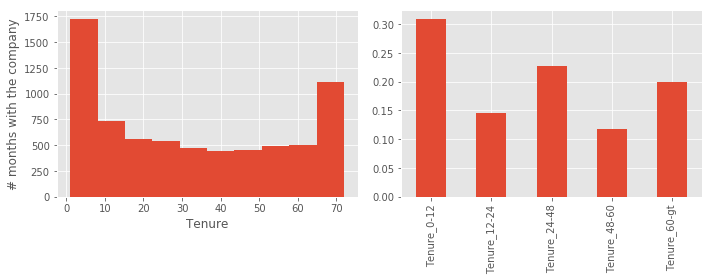

In [8]:
#Tenure to categorical column
def tenure_lab(data):    
    if data['tenure'] <= 12 :
        return "Tenure_0-12"
    elif (data['tenure'] > 12) & (data['tenure'] <= 24 ):
        return "Tenure_12-24"
    elif (data['tenure'] > 24) & (data['tenure'] <= 48) :
        return "Tenure_24-48"
    elif (data['tenure'] > 48) & (data['tenure'] <= 60) :
        return "Tenure_48-60"
    elif data['tenure'] > 60 :
        return "Tenure_60-gt"
data["tenure_group"] = data.apply(lambda data:tenure_lab(data), axis = 1)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(10,4))

data['tenure'].hist(density=False, ax=ax1)
data['tenure_group'].value_counts(ascending=False, sort=True, normalize=True).sort_index().plot.bar(ax=ax2)

ax1.set_xlabel(r'Tenure')
ax1.set_ylabel(r'# months with the company')
plt.tight_layout()

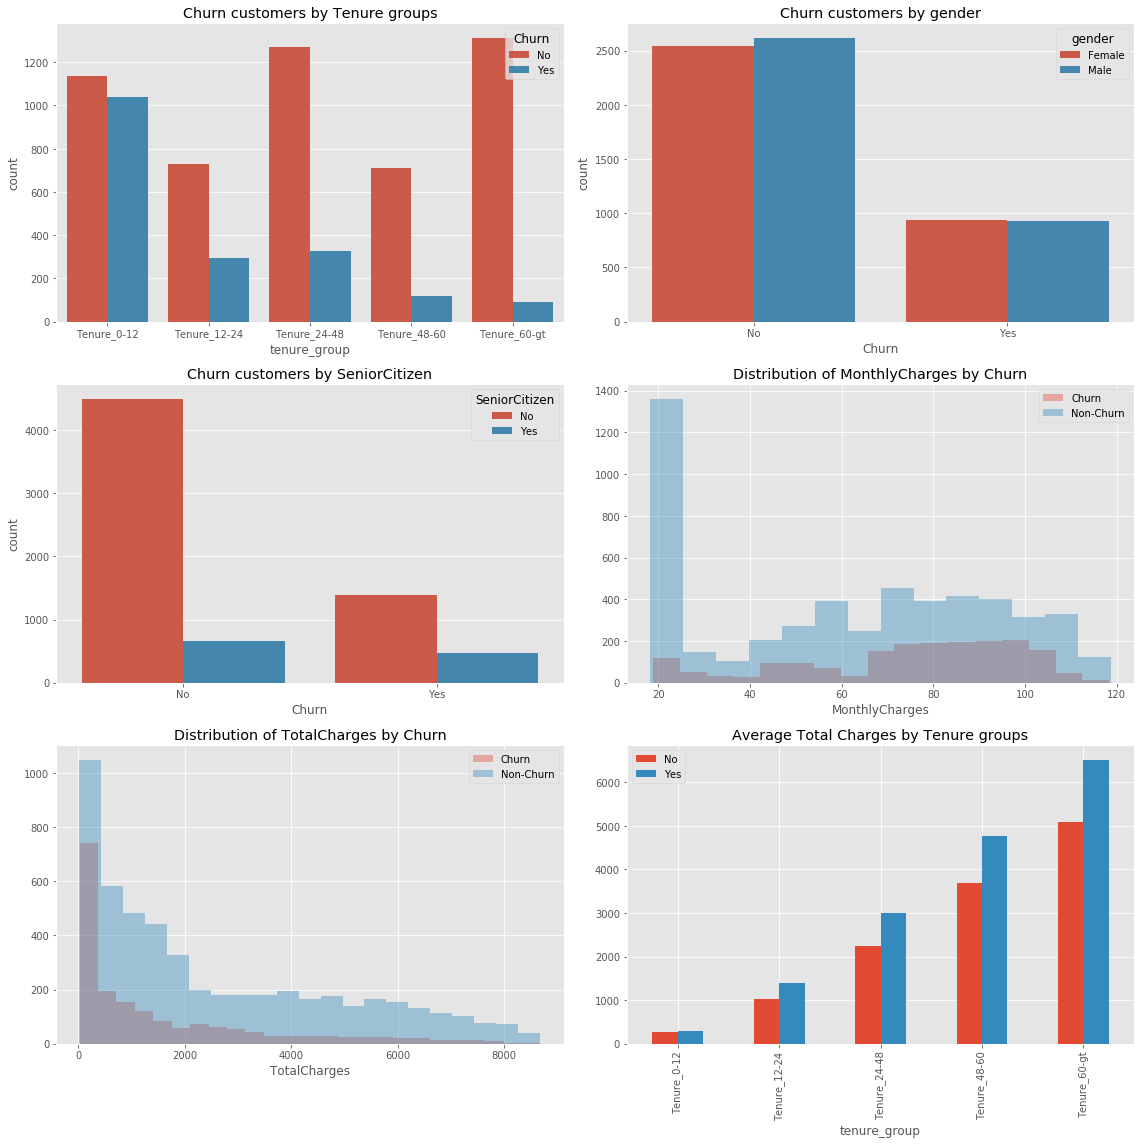

In [9]:
order_tenure = list(data['tenure_group'].value_counts(ascending=False, sort=True, normalize=True).sort_index().index)

f, axes = plt.subplots(3, 2, sharey=False, sharex=False, figsize=(16,16))

sns.countplot(x='tenure_group', hue='Churn', data=data, order=order_tenure, orient='v', ax=axes[0,0])
sns.countplot(x='Churn', hue='gender', data=data, orient='v', ax=axes[0,1])
sns.countplot(x='Churn', hue='SeniorCitizen', data=data, orient='v', ax=axes[1,0])
sns.distplot(data[data['Churn']=='Yes']['MonthlyCharges'], kde=False, hist=True, norm_hist=False, ax=axes[1,1], label='Churn')
sns.distplot(data[data['Churn']=='No']['MonthlyCharges'], kde=False, hist=True, norm_hist=False, ax=axes[1,1], label='Non-Churn')

sns.distplot(data[data['Churn']=='Yes']['TotalCharges'], kde=False, hist=True, norm_hist=False, ax=axes[2,0], label='Churn')
sns.distplot(data[data['Churn']=='No']['TotalCharges'], kde=False, hist=True, norm_hist=False, ax=axes[2,0], label='Non-Churn')

pivot = pd.pivot_table(data, values=['MonthlyCharges', 'TotalCharges'], index=['tenure_group', 'Churn'])

pivot.unstack()['TotalCharges'].plot.bar(ax=axes[2,1], title='Average Total Charges by Tenure groups')

axes[0,0].set_title('Churn customers by Tenure groups')
axes[0,1].set_title('Churn customers by gender')
axes[1,0].set_title('Churn customers by SeniorCitizen')
axes[1,1].set_title('Distribution of MonthlyCharges by Churn')
axes[2,0].set_title('Distribution of TotalCharges by Churn')

axes[1,1].legend()
axes[2,0].legend()
axes[2,1].legend()
plt.tight_layout()

In [10]:
from sklearn.preprocessing import LabelEncoder

dataobject=data.select_dtypes(['object'])

def uni(columnname):
    print(columnname,"--" ,data[columnname].unique())

for i in range(1,len(dataobject.columns)):
    uni(dataobject.columns[i])
    
def labelencode(columnname):
    data[columnname] = LabelEncoder().fit_transform(data[columnname])
    
for i in range(1,len(dataobject.columns)):
    labelencode(dataobject.columns[i])
        
for i in range(1,len(dataobject.columns)):
     uni(dataobject.columns[i])
    
df = data.copy()
drop_list = ['customerID', 'gender', 'Dependents', 'PhoneService', 'DeviceProtection', 'TechSupport',
             'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'PaymentMethod']

df['Contract_0'] = ((df['Contract']==0).values).astype(int)
df['Contract_1'] = ((df['Contract']==1).values).astype(int)
df['Contract_2'] = ((df['Contract']==2).values).astype(int)

df['tenure_0'] = ((df['tenure_group']==0).values).astype(int)
df['tenure_1'] = ((df['tenure_group']==1).values).astype(int)
df['tenure_2'] = ((df['tenure_group']==2).values).astype(int)
df['tenure_3'] = ((df['tenure_group']==3).values).astype(int)
df['tenure_4'] = ((df['tenure_group']==4).values).astype(int)

df = df.drop(drop_list, axis=1)
df = df.drop(['Contract', 'tenure', 'tenure_group'], axis=1)

gender -- ['Female' 'Male']
SeniorCitizen -- ['No' 'Yes']
Partner -- ['Yes' 'No']
Dependents -- ['No' 'Yes']
PhoneService -- ['No' 'Yes']
MultipleLines -- ['No' 'Yes']
InternetService -- ['DSL' 'Fiber optic' 'No']
OnlineSecurity -- ['No' 'Yes']
OnlineBackup -- ['Yes' 'No']
DeviceProtection -- ['No' 'Yes']
TechSupport -- ['No' 'Yes']
StreamingTV -- ['No' 'Yes']
StreamingMovies -- ['No' 'Yes']
Contract -- ['Month-to-month' 'One year' 'Two year']
PaperlessBilling -- ['Yes' 'No']
PaymentMethod -- ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn -- ['No' 'Yes']
tenure_group -- ['Tenure_0-12' 'Tenure_24-48' 'Tenure_12-24' 'Tenure_60-gt' 'Tenure_48-60']
gender -- [0 1]
SeniorCitizen -- [0 1]
Partner -- [1 0]
Dependents -- [0 1]
PhoneService -- [0 1]
MultipleLines -- [0 1]
InternetService -- [0 1 2]
OnlineSecurity -- [0 1]
OnlineBackup -- [1 0]
DeviceProtection -- [0 1]
TechSupport -- [0 1]
StreamingTV -- [0 1]
StreamingMovies -- [0 1]
Contract -

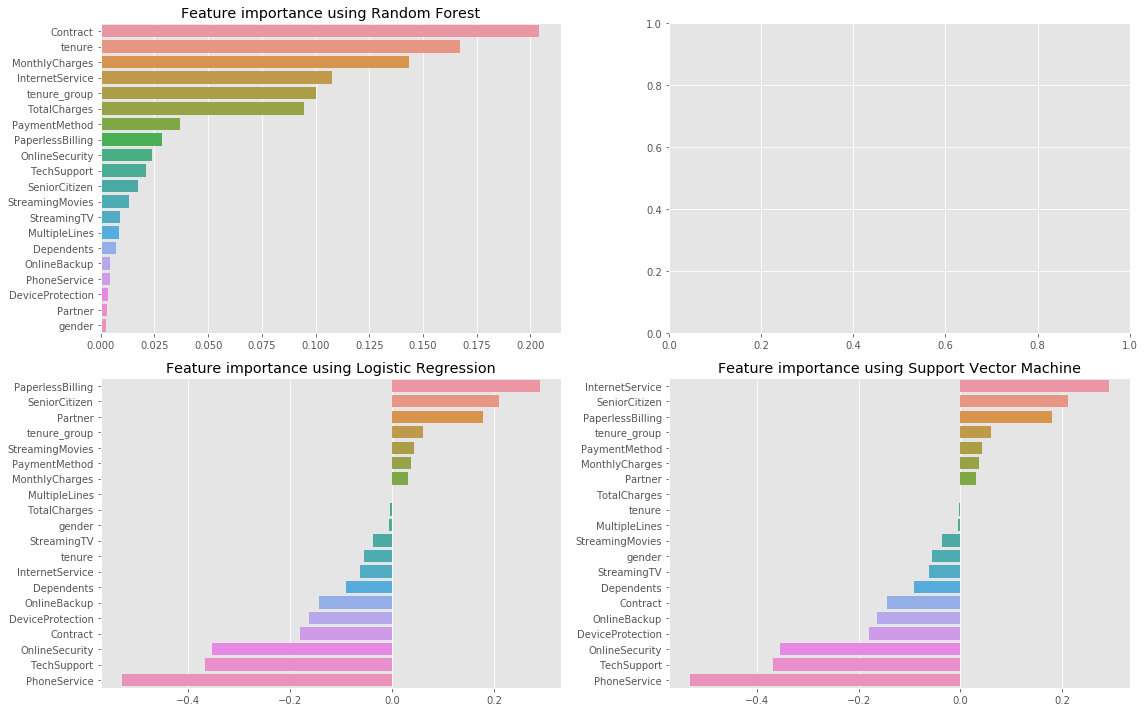

In [25]:
f, axes = plt.subplots(2, 2, sharey=False, sharex=False, figsize=(16,10))

imp1 = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
imp2 = pd.Series(data=logreg.coef_[0], index=x.columns).sort_values(ascending=False)
imp3 = pd.Series(data=svm.coef_[0], index=x.columns).sort_values(ascending=False)

sns.barplot(y=imp1.index, x=imp1.values, orient='h', ax=axes[0,0])
sns.barplot(y=imp2.index, x=imp3.values, orient='h', ax=axes[1,0])
sns.barplot(y=imp3.index, x=imp4.values, orient='h', ax=axes[1,1])



axes[0,0].set_title("Feature importance using Random Forest")
axes[1,0].set_title("Feature importance using Logistic Regression")
axes[1,1].set_title("Feature importance using Support Vector Machine")

plt.tight_layout();

## Prediction

In [0]:
from sklearn.model_selection import train_test_split
data_to_train = data.drop(['customerID'], axis=1).copy()

train_set, validation_set = train_test_split(data_to_train.copy(), test_size=0.30)

#to perform cross-validation
target_to_train = data_to_train['Churn']
data_to_train = data_to_train.drop(['Churn'], axis=1)

#to perform holdout-set
train_target = train_set['Churn']
train_set = train_set.drop(['Churn'], axis=1)

validation_target = validation_set['Churn']
validation_set = validation_set.drop(['Churn'], axis=1)

x, y = train_set, train_target


In [0]:
from sklearn.ensemble import RandomForestClassifier

# Fit RandomForest Classifier
clf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
clf.fit(x, y);

In [0]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x, y);

In [0]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=0.01) 
svm.fit(x, y);

##Model evaluation

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve, auc

###Accuracy

In [19]:
# Here is the accuracy of Logistic Regression as 0.789
train_x,test_x,train_y,test_y = train_test_split(train_set,train_target,random_state=30,test_size=0.2)
model_Log = LogisticRegression(random_state=34)
model_Log.fit(train_x,train_y)
print("Accuracy using LogisticRegression ",accuracy_score(test_y,model_Log.predict(test_x)))

Accuracy using LogisticRegression  0.7898477157360406


In [20]:
# and here is the accuracy of Random Forest Classifier, as 0.768
model_RFC = RandomForestClassifier(random_state=45)
model_RFC.fit(train_x,train_y)
print("Accuracy using RandomForestClassifier ",accuracy_score(test_y,model_RFC.predict(test_x)))

Accuracy using RandomForestClassifier  0.7685279187817259


In [21]:
# here is the accuracy of SVM:C=0.8, kernel='linear' , as 0.794
clf1 = svm.SVC(C=0.8, kernel='linear', decision_function_shape='ovr')
clf1.fit(train_x, train_y)
print(clf1.score(train_x, train_y))

0.794005588011176


###ROC,RUC,GRIDSEARCH

<Figure size 432x288 with 0 Axes>

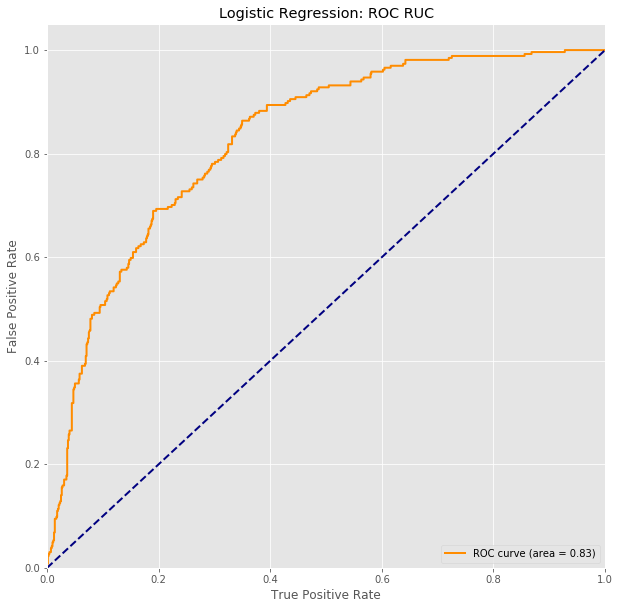

In [23]:
# ROC RUC for Logistic Regression
predictions=model_Log.predict_proba(test_x)
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions[:, 1])
roc_auc=auc(false_positive_rate,recall)
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.title('Logistic Regression: ROC RUC')
plt.plot(false_positive_rate, recall, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],color='navy',lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.show()

<Figure size 432x288 with 0 Axes>

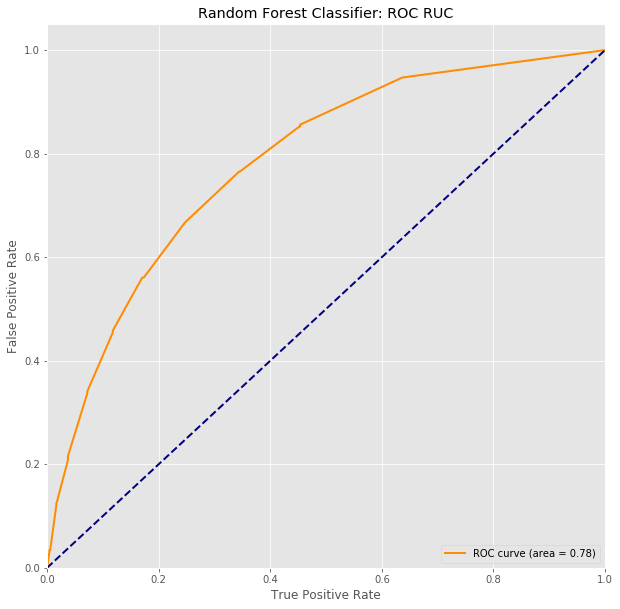

In [24]:
# ROC RUC for Random Forest Classifier
predictions=model_RFC.predict_proba(test_x)
false_positive_rate, recall, thresholds = roc_curve(test_y, predictions[:, 1])
roc_auc=auc(false_positive_rate,recall)
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.title('Random Forest Classifier: ROC RUC')
plt.plot(false_positive_rate, recall, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],color='navy',lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.show()

<Figure size 432x288 with 0 Axes>

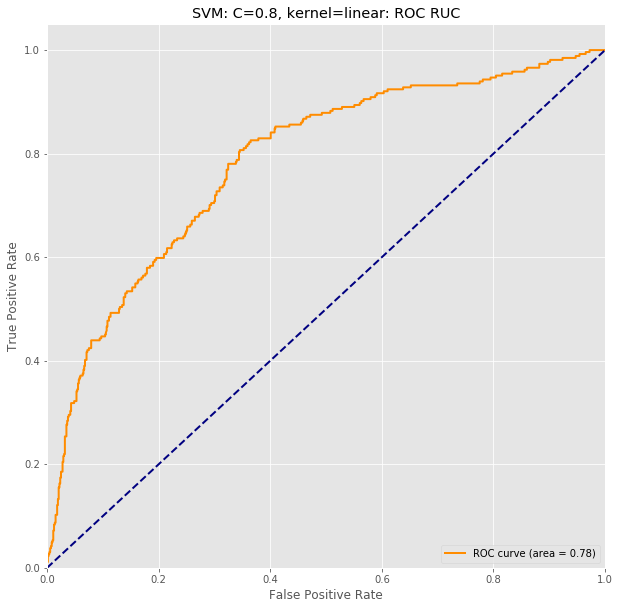

In [25]:
# ROC RUC curve for SVM: C=0.8, kernel='linear'
from sklearn.metrics import roc_curve, auc
y_score = clf1.fit(train_x, train_y).decision_function(test_x)
fpr,tpr,threshold = roc_curve(test_y, y_score)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM: C=0.8, kernel=linear: ROC RUC')
plt.legend(loc="lower right")
plt.show()

In [0]:
# SVM GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
parameters = {'kernel':('linear', 'rbf'), 'C':[0.8,0.9,1]}
svr = svm.SVC()
clf = GridSearchCV(svr, parameters, scoring='f1_macro', cv=5)
result = clf.fit(train_x, train_y)
# Result of SVM GridSearch
result_svc = pd.DataFrame(result.cv_results_)
result_svc.sort_values(by='mean_test_score', ascending=False).head(5)

###Confusion matrix

0.7908629441624365

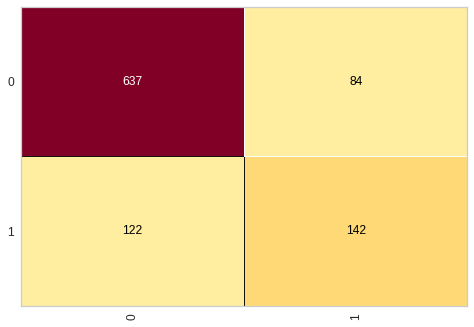

In [27]:
from yellowbrick.classifier import ConfusionMatrix

xgb = XGBClassifier()
xgb.fit(train_x,train_y)

y_pred = xgb.predict(test_x)
xgb_accy_train = round(xgb.score(train_x,train_y),2)
xgb_accy = round(xgb.score(test_x,test_y),2)

cm = ConfusionMatrix(xgb, classes=[0,1])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(train_x,train_y)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(test_x,test_y)

##Prediction

In [0]:
model_Log = LogisticRegression(random_state=45)
model_Log.fit(train_set,train_target)
pred = model_Log.predict(test_x)

In [30]:
## Prediction 
# It turns out the Logistic regression has the higher accuracy number, 
# so I run this model on the test dataset,and it will return me with a list as below
prediction = pd.DataFrame({
        "id": id,
        "Outcome": pred
    })
print(prediction)

                         id  Outcome
0    <built-in function id>        0
1    <built-in function id>        0
2    <built-in function id>        1
3    <built-in function id>        0
4    <built-in function id>        0
5    <built-in function id>        0
6    <built-in function id>        0
7    <built-in function id>        0
8    <built-in function id>        0
9    <built-in function id>        0
10   <built-in function id>        1
11   <built-in function id>        0
12   <built-in function id>        1
13   <built-in function id>        0
14   <built-in function id>        0
15   <built-in function id>        1
16   <built-in function id>        0
17   <built-in function id>        1
18   <built-in function id>        0
19   <built-in function id>        0
20   <built-in function id>        1
21   <built-in function id>        0
22   <built-in function id>        0
23   <built-in function id>        1
24   <built-in function id>        1
25   <built-in function id>        0
2

## Recommendation
1. Given the fact that the most of customers doesn't have additional products, choosing simple plans that doesn't contains special products. The company should make sure the demand from the most customers are well satisfied. 
2. The most of contracts are specified as Month-to-month consists about 55% of all contracts,revealing much marketing potential. In terms of age and gender of the customers, we have just 15% of seniors citizen. Thus young people would be a good target audeince if do some marketing campaign.
3. About 31% of customers stay with the company about one year, this period is the most common. Only 20% are greater than or equal to four years, in other words, only 20% continues in the company before four years of contract. Company should focus on keeping the 31% customers before they end the contract.
4. Total charges, internet services, seniority, for example, can lead to higher churn rates. This is interesting because although fibre optic services are faster, customers are likely to churn because of it, probably because you have to pay more, contributing to total charges. 